# CB1020 Project in mathematical modeling

## Lecture 2: Agent-based model (ABM)

### Patrick Norman

Python naturally invites to good software engineering practices in terms of [object-oriented programming](https://www.w3schools.com/python/python_classes.asp). Almost everything in Python is an `object`, with its properties and methods.

Classes are central to object-oriented programming and we begin with a short reminder of the concept as it will be used in the construction of ABMs.

# Classes and object-oriented programming

A `class` is like an object constructor, or a “blueprint” for creating objects known as *instances* of the class.

It cannot be overemphasized that the use of object-oriented programming is highly enabling for code sharing and team development, and it is strongly recommended to adopt these practices.

## Create a class

As an example, we implement a *class* `Person` with a *method* `length_name` and *attributes* `first` and `last`.

In [ ]:
class Person:
    def __init__(self, first_name, last_name):
        self.first = first_name
        self.last = last_name

    def __str__(self):
        return f"Name: {self.first} {self.last}"

    def length_name(self):
        return len(self.first + self.last)

## Create a class instance

In [ ]:
p = Person("Patrick", "Norman")

In [ ]:
print(type(p))
print(p.first, p.last)

When the `__str__` method is defined, we can directly use `print()` on the class instance. 

In [ ]:
print(p)

The instance reference is automatically passed as the first argument to the methods. By convention, this argument should be recieved as a parameter named `self`.

The `__init__` method is executed every time a new instance of the class is created.

## Derived classes

Inheritance allows us to define a class that inherits all the methods and properties from another class.

- Parent (or base) class is the class being inherited from
- Child (or derived) class is the class that inherits from another class

To create a class that inherits the functionality from another class, send the base class as a parameter when creating the derived class.

In [ ]:
class FamilyMember(Person):
    def __init__(self, first_name, last_name, relation):
        super().__init__(first_name, last_name)
        self.relation = relation

    def __str__(self):
        return f"Name: {self.first} {self.last}\nRelation: {self.relation}"

When an `__init__()` function is defined for the derived class, it overrides that of the base class. We can add an explicit call to the `__init__()` function of the base class with `super()`.

We create an instance of the derived class.

In [ ]:
fm = FamilyMember("Alexander", "Norman", "son")

In [ ]:
print(type(fm))
print(fm)

In [ ]:
print(f"Length of name of family member: {fm.length_name()}")

# Agent-based modeling

An [agent-based model](https://en.wikipedia.org/wiki/Agent-based_model) (ABM) is a computational model for simulating the actions and interactions of autonomous agents (both individual or collective entities such as organizations or groups) in order to understand the behavior of a system and what governs its outcomes.

[Mesa](https://mesa.readthedocs.io/en/stable/overview.html) is a Python framework for agent-based modeling. It contains three categories of modules:

1. **Modeling**: Modules used to build the models themselves: a model and agent classes, a scheduler to determine the sequence in which the agents act, and space for them to move around on.

2. **Analysis**: Tools to collect data generated from your model, or to run it multiple times with different parameter values.

3. **Visualization**: Classes to create and launch an interactive model visualization, using a server with a JavaScript interface.

Every ABM requires two classes, one for the overall model and one for the agents. These classes will be derived classes of Mesa's base classes `Model` and `Agent`. 

The model class holds the model-level attributes, manages the agents, and generally handles the global level of our model. 

## Importing Mesa 

In [ ]:
# Modeling
from mesa import Agent, Model

# Analysis
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid

## Defining the model

- $N$ agents are randomly walking around in a 2D landscape grid of cells
- To begin with, the agents are randomly positioned and has one unit of wealth
- If an agent has nonzero wealth and enters into a non-empty cell, the agent will give one unit of wealth to a random cellmate
- Focus is set on wealth distribution over time

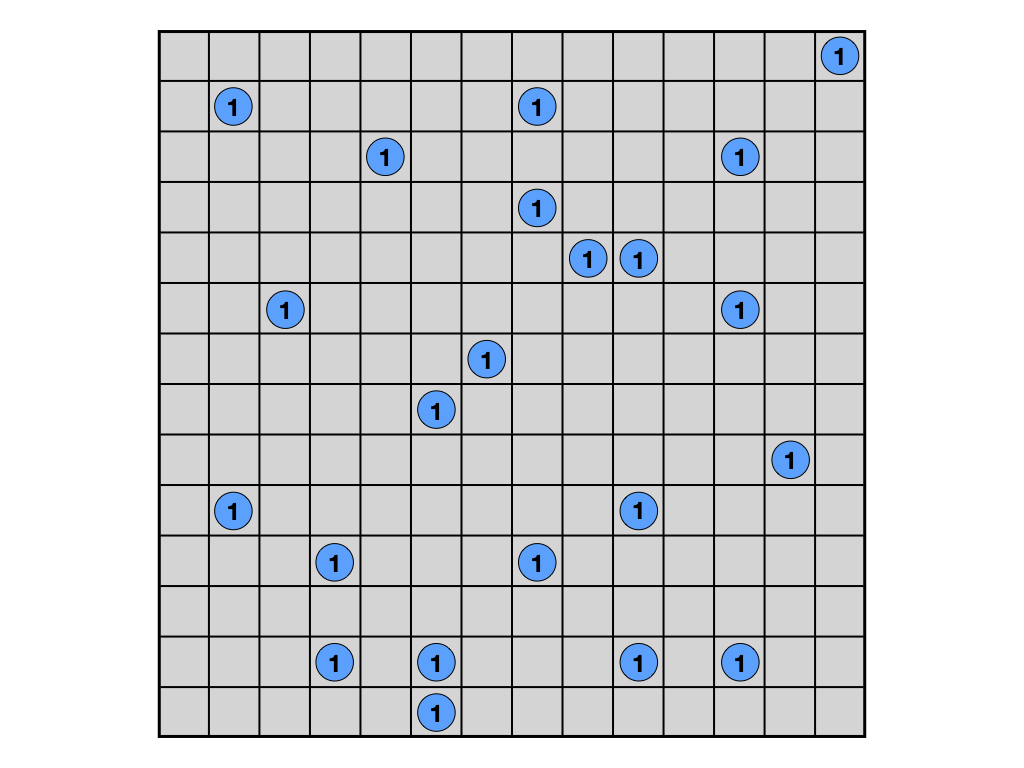

## Implementing the metric

As metric indicator of wealth distribution, we implement the [Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient). Let $x_i$ for $i = 1,\ldots, N$ be the wealth of $N$ individuals ordered such that $x_i \leq x_{i+1}$. The Gini coefficient for this population is

$$
G = \frac{1}{N}
\Big(
N + 1 - \frac{2}{X} \sum_{i=1}^N (N+1-i) x_i
\Big)
$$

where $X$ is the sum of wealths, or, in other words, the total population wealth. There are two limting values for $G$. If every individual has the same wealth, then $G = 0$. If the total population wealth belongs to a single individual, then $G = (1 - 1/N)$.

In [ ]:
def compute_gini(model):
    N = model.num_agents

    # collect wealth of agents into a list and sort it in increasing order
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)

    # calculate the Gini coefficient
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / sum(x)
    G = (N + 1 - 2 * B) / N

    return G

# Implmenting the model

Create a model that defines a data collector that in each time step records the wealth of agents and the overall indicator for wealth distribution.

In [ ]:
class MoneyModel(Model):
    def __init__(self, N, width, height):
        # run the __init__ method of the parent class
        super().__init__()
        # additional initialization for the derived class
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.datacollector = DataCollector(
            model_reporters={
                "Gini coefficient": compute_gini  # function defined below
            },
            agent_reporters={
                "Agent wealth": "wealth",
                "Agent position": "pos",
            },  # agent attributes
        )

        # Create agents
        for unique_id in range(self.num_agents):
            agent = MoneyAgent(self)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("step")

## Agents
Every agent starts with a wealth of 1. If an agent has nonzero wealth and enters into a non-empty cell, the agent will give one unit of wealth to a random cellmate.

In [ ]:
class MoneyAgent(Agent):
    def __init__(self, model):
        # run the __init__ method of the parent class
        super().__init__(model)

        # additional initialization for the derived class
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,  # current position
            moore=True,  # including step on the diagonal
            include_center=False,  # to remain at current position is not allowed
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

# Running the simulation

We run the model with 1,000 agents distributed in a 100 $\times$ 100 grid of cells for 1,000 time steps.

In [ ]:
model = MoneyModel(1000, 100, 100)
for _ in range(1000):
    model.step()

# Analyzing the simulation

## Collecting stored data

After the simulation, we collect the model and agent data that are stored using the [Pandas](https://pandas.pydata.org/docs/getting_started/overview.html) `DataFrame` data structure.

In [ ]:
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

We expose the data structures with use of the methods `head(n)` and `tail(n)` showing, respectively, the first and last *n* rows of the dataframes.

In [ ]:
model_df.head(5)

In [ ]:
agent_df.tail(5)

## Plotting results

In [ ]:
import matplotlib.pyplot as plt

model_df.plot(color="r", lw=3, figsize=(10, 6))

plt.ylabel("Gini coefficient")
plt.xlabel("Time step")
plt.grid("on")
plt.setp(plt.gca(), xlim=(-1, 1000), ylim=(0, 1))

plt.show()

In [ ]:
# extract a cross section of the dataframe for the final time step
final_wealth_df = agent_df.xs(99, level="Step")

final_wealth_df.hist(bins=range(11), figsize=(8, 6))

plt.title("Wealth distribution")
plt.ylabel("Number agents")
plt.xlabel("Wealth")
plt.setp(
    plt.gca(), xlim=(0, 10), xticks=range(11), ylim=(0, 500), yticks=range(0, 501, 50)
)

plt.show()

Let us find the agent that accumulated maximum wealth and the time step at which this occured.

In [ ]:
step_idx, agent_idx = agent_df.idxmax().iloc[0]

print("Agent:", agent_idx)
print("Step:", step_idx)

Let us plot the time series of wealth for this agent.

In [ ]:
one_agent_wealth_df = agent_df.xs(agent_idx, level="AgentID")

one_agent_wealth_df.plot(lw=2, color="b", figsize=(10, 4))

plt.ylabel(f"Wealth of Agent {agent_idx}")
plt.xlabel("Time step")
plt.grid(True)
plt.setp(
    plt.gca(),
    xlim=(0, 1000),
    xticks=range(0, 1001, 100),
    ylim=(0, 15),
    yticks=range(16),
)
plt.show()

## The end